In [1]:
### Adapted from Lars code

In [7]:
#!pip install zfit
#!pip install hepstats

In [45]:
import math
import uproot
import zfit
import matplotlib
import scipy
import matplotlib.pyplot as plt
import numpy             as np

from scipy                          import interpolate 
from hepstats.hypotests             import ConfidenceInterval, UpperLimit
from hepstats.hypotests.calculators import AsymptoticCalculator, FrequentistCalculator
from hepstats.hypotests.parameters  import POIarray, POI

matplotlib.rc('text',   usetex    = False)
matplotlib.rc('font',   family    = 'serif')
matplotlib.rc('axes',   labelsize = 14)
matplotlib.rc('axes',   titlesize = 18)
matplotlib.rc('font',   size      = 12)
matplotlib.rc('legend', fontsize  = 10)
matplotlib.rc('xtick',  labelsize = 12)
matplotlib.rc('ytick',  labelsize = 12)

In [9]:
def find_zero_crossing(x,y):
    tck = scipy.interpolate.splrep(x,y,s=0)
    return scipy.interpolate.sproot(tck)

def set_border_line_width(ax: matplotlib.axes, lineWidth: float) -> None:
    """
    Utility function for getting the frame of an axis and setting the line width
    """
    [axis.set_linewidth(lineWidth) for axis in ax.spines.values()]
    
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(math.floor(math.log10(abs(num))))
    coeff = round(num / float(10 ** exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"{0:.{2}f}$\cdot$10$^{{{1:d}}}$".format(coeff, exponent, precision)

## Background model

Data are provided by Toby Dixon. L200 p03 to p09, ICPCs

In [30]:
data_path = '/Users/romoluque_c/LEGEND/2nbb_distortions/data_bckg_model/'

bin_midpnts, tot_model = np.loadtxt(data_path + 'l200_p03_to_p09_icpc_total_model.txt', usecols=(0,1), unpack=True, skiprows=1, delimiter=',')
alphas_model           = np.loadtxt(data_path + 'l200_p03_to_p09_icpc_alphas.txt',      usecols=(1),   unpack=True, skiprows=1, delimiter=',')
co60_model             = np.loadtxt(data_path + 'l200_p03_to_p09_icpc_Co60_chain.txt',  usecols=(1),   unpack=True, skiprows=1, delimiter=',')
k40_model              = np.loadtxt(data_path + 'l200_p03_to_p09_icpc_K40_chain.txt',   usecols=(1),   unpack=True, skiprows=1, delimiter=',')
k42_model              = np.loadtxt(data_path + 'l200_p03_to_p09_icpc_K42_chain.txt',   usecols=(1),   unpack=True, skiprows=1, delimiter=',')
vvBB_model             = np.loadtxt(data_path + 'l200_p03_to_p09_icpc_Nvbb.txt',        usecols=(1),   unpack=True, skiprows=1, delimiter=',')
Th_model               = np.loadtxt(data_path + 'l200_p03_to_p09_icpc_Th_chain.txt',    usecols=(1),   unpack=True, skiprows=1, delimiter=',')
U_model                = np.loadtxt(data_path + 'l200_p03_to_p09_icpc_U_chain.txt',     usecols=(1),   unpack=True, skiprows=1, delimiter=',')
L200_actual_data       = np.loadtxt(data_path + 'l200_p03_to_p09_icpc_fitted_data.txt', usecols=(1),   unpack=True, skiprows=1, delimiter=',')

# From Neutrino2024 talk
L200_data_exposure = 76.2 #kg * yr

######## Normalize by exposure
total_model      = tot_model        / L200_data_exposure
alphas_model     = alphas_model     / L200_data_exposure
co60_model       = co60_model       / L200_data_exposure
k40_model        = k40_model        / L200_data_exposure
k42_model        = k42_model        / L200_data_exposure
vvBB_model       = vvBB_model       / L200_data_exposure
Th_model         = Th_model         / L200_data_exposure
U_model          = U_model          / L200_data_exposure
L200_actual_data = L200_actual_data / L200_data_exposure

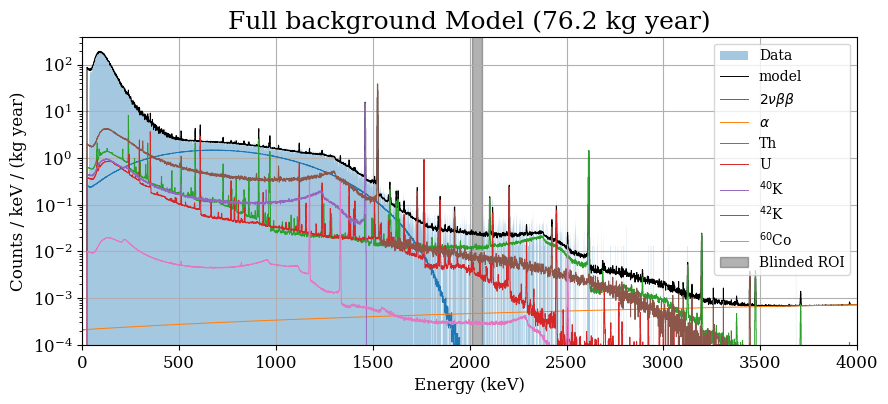

In [31]:
bckg_bin_left_edges = bin_midpnts - 0.5

fig, ax = plt.subplots(figsize=(10, 4))

ax.fill_between(bckg_bin_left_edges, 0, L200_actual_data, label=r'Data', alpha=0.4)
#ax.step(bckg_bin_left_edges, L200_actual_data, label=r'Data', alpha=0.3)
ax.step(bckg_bin_left_edges, total_model,  where='post', lw=0.7, label='model', color='black')
ax.step(bckg_bin_left_edges, vvBB_model,   where='post', lw=0.7, label=r'$2\nu\beta\beta$')
ax.step(bckg_bin_left_edges, alphas_model, where='post', lw=0.7, label=r'$\alpha$')
ax.step(bckg_bin_left_edges, Th_model,     where='post', lw=0.7, label=r'Th')
ax.step(bckg_bin_left_edges, U_model,      where='post', lw=0.7, label=r'U')
ax.step(bckg_bin_left_edges, k40_model,    where='post', lw=0.7, label=r'$^{40}$K')
ax.step(bckg_bin_left_edges, k42_model,    where='post', lw=0.7, label=r'$^{42}$K')
ax.step(bckg_bin_left_edges, co60_model,   where='post', lw=0.7, label=r'$^{60}$Co')

# Shade blinded ROI
qbb      = 2039 # keV
roi_ampl =   50 # keV
ax.fill_between([qbb - roi_ampl/2, qbb + roi_ampl/2], 0, 1e5, label=r'Blinded ROI', alpha=0.3, color='black')

ax.grid()
ax.legend(loc='upper right')
ax.set_yscale('log')
ax.set_ylabel('Counts / keV / (kg year)')
ax.set_xlabel('Energy (keV)')
ax.set_ylim(1e-4, 4e2)
ax.set_xlim(0, 4000)
ax.set_title(f'Full background Model ({L200_data_exposure} kg year)')
plt.show()

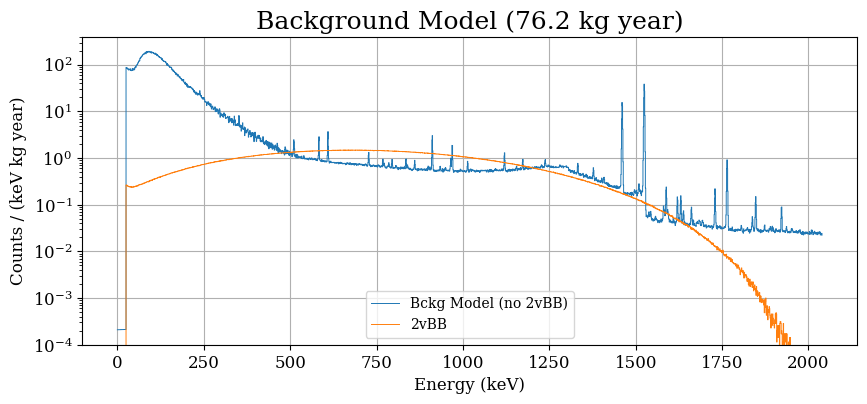

In [32]:
# For use in fitting code define the background_model, vvBB_model, background_bin_left_edges, L200_actual_data
# Crop all to the range [0, 2039.999...]
bckg_model          = (total_model - vvBB_model)[0:2039 + 1]
vvBB_model          = vvBB_model                [0:2039 + 1]
bckg_bin_left_edges = bckg_bin_left_edges       [0:2039 + 1]
L200_actual_data    = L200_actual_data          [0:2039 + 1]

fig, ax = plt.subplots(figsize=(10, 4))
ax.step(bckg_bin_left_edges, bckg_model, where='post', lw=0.7, label='Bckg Model (no 2vBB)')
ax.step(bckg_bin_left_edges, vvBB_model, where='post', lw=0.7, label='2vBB')
ax.set_yscale('log')
ax.set_ylim(1e-4, 4e2)
ax.set_title(f'Background Model ({L200_data_exposure} kg year)')
ax.set_ylabel("Counts / (keV kg year)")
ax.set_xlabel('Energy (keV)')
ax.set_xlim()
ax.grid()
ax.legend()
plt.show()

## Right Handed Currents Spectra

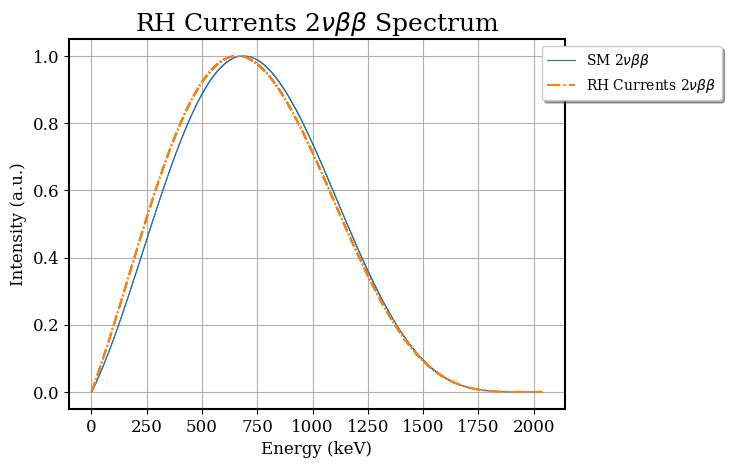

In [43]:
basepath     = '/Users/romoluque_c/LEGEND/2nbb_distortions/Spectral_Effects_Fitting_Lars/L200_Spectral_Effects_Fitting/'
rh_curr_dist = np.loadtxt(basepath+'/dist/rh_curr/Ge-RHC-Etot-distro-1kev-reinterpolated.dat', usecols=(1), unpack=True)

# Add bin at 0 to match background model
rh_curr_dist = np.insert(rh_curr_dist, 0, 0, axis=0)

# Normalize to area = 1
rh_curr_dist = rh_curr_dist / np.sum(rh_curr_dist)

sm_nnbb_dist = np.loadtxt(basepath+'/dist/standard_model/SM_2vbb_76Ge_sums.txt', usecols=(2), unpack=True)
sm_nnbb_dist = np.insert(sm_nnbb_dist, 0, 0, axis=0)

fig, ax = plt.subplots()
ax.step(bckg_bin_left_edges, sm_nnbb_dist / np.max(sm_nnbb_dist), where='post', lw=0.8,  label=r'SM 2$\nu\beta\beta$')
ax.step(bckg_bin_left_edges, rh_curr_dist / np.max(rh_curr_dist), where='post', ls='-.', label=r'RH Currents 2$\nu\beta\beta$', )

ax.legend(loc = 'upper right', ncol=1, fancybox=True, shadow=True, bbox_to_anchor = (1.33, 1))
ax.grid()
set_border_line_width(ax, 1.5)
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Intensity (a.u.)')
ax.set_title(r'RH Currents 2$\nu\beta\beta$ Spectrum')
#fig.savefig('./figs/rh_curr/spectra.pdf', bbox_inches='tight')

plt.show()

## Sensitivity calculations

FitResult of
<ExtendedBinnedNLL model=[<zfit.models.binned_functor.BinnedSumPDF object at 0x2a14dc4f0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x2a2b94c40>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.1e-05 │       -501325.52 |  4992.853 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name            value  (rounded)     hesse_np    at limit
------------  ------------------  -----------  ----------
n_signal                 43504.2  +/- 2.6e+04       False
n_background             55655.4  +/- 4.7e+02       False
n_2vBB                   26102.8  +/- 2.6e+04       False


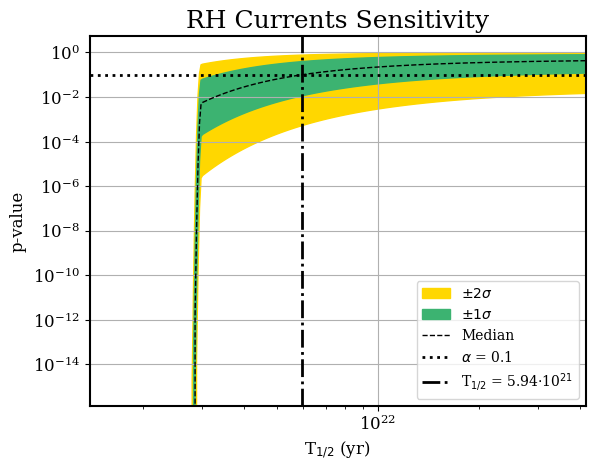

Using background model: 


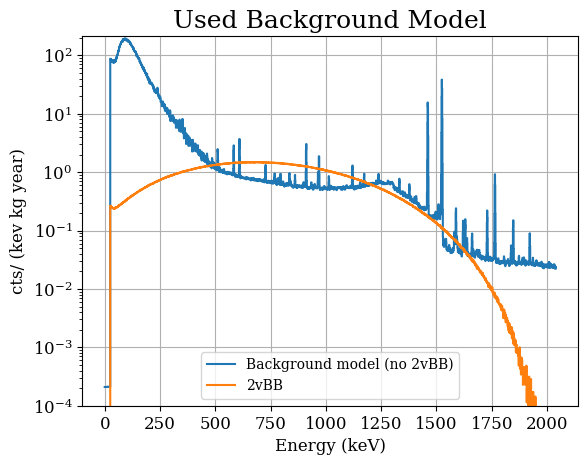

In [46]:
# Significance Level
alpha = 0.1

# Fit range left endpoints min and max inclusive [min, max]
min_bin = 560
max_bin = 2010

# L200_data_exposure = 76.2 kg yr
exposure = L200_data_exposure

NA = 6.022141e23 # Avogadro's constant: atoms / mol
mA = 75.9214027e-3 # kg / mol of 76Ge
half_life_76Ge = 2.022e21 # yr (From GERDA, 2308.09795)

# explain?
efficiency = 0.75

# Input for fitting
signal_dist = rh_curr_dist

N_min = 5_000
N_max = 150_000

# ===========================================================================

# Cut the distribution in the fit range
limits                  = (min_bin, max_bin + 1)
binning                 = max_bin + 1 - min_bin
bin_left_edges_fitrange = bckg_bin_left_edges[min_bin:max_bin + 1]
bckg_model_fitrange     = bckg_model         [min_bin:max_bin + 1]
vvBB_model_fitrange     = vvBB_model         [min_bin:max_bin + 1]

# Calculate the number of background and 2vBB events
Nbckg = exposure * np.sum(bckg_model_fitrange)
NvvBB = exposure * np.sum(vvBB_model_fitrange)

# Setup zfit values
obs      = zfit.Space    ('E', limits=limits, binning=binning)
n_signal = zfit.Parameter('n_signal',         0, 0, step_size=0.01)
n_bckg   = zfit.Parameter('n_background', Nbckg, 0, step_size=0.01)
n_vvBB   = zfit.Parameter('n_2vBB',       NvvBB, 0, step_size=0.01)

# Pdfs
bckg_model_pdf = zfit.pdf.HistogramPDF(zfit.data.BinnedData.from_tensor(space=obs, values=bckg_model_fitrange), extended=n_bckg)
vvBB_pdf       = zfit.pdf.HistogramPDF(zfit.data.BinnedData.from_tensor(space=obs, values=vvBB_model_fitrange), extended=n_vvBB)

signal_dist_fitrange = signal_dist[min_bin:max_bin + 1]
signal_fitrange_eff  = np.sum(signal_dist_fitrange) # sig_distribution already normalized to 1
signal_pdf           = zfit.pdf.HistogramPDF(zfit.data.BinnedData.from_tensor(space=obs, values=signal_dist_fitrange), extended=n_signal)
# Model (signal + background)
# Since both signal_pdf and background_model_pdf are extended PDF's we should not specify the fraction of each PDF
model = zfit.pdf.BinnedSumPDF([signal_pdf, bckg_model_pdf, vvBB_pdf])

n_signal.set_value(0)
n_bckg  .set_value(Nbckg)
n_vvBB  .set_value(NvvBB)

real_data = zfit.data.BinnedData.from_tensor(space=obs, values=(exposure * L200_actual_data[min_bin: max_bin + 1]))

# In theory the 'subtr_const': True should offset the loss function closer to 0. In practice the opposite is true.
# After perusing the source code (https://zfit.readthedocs.io/en/v0.18.1/_modules/zfit/core/loss.html)
# I see zfit is calculating `log_offset = (NLL - 10000) / nEventsTot` which is completely bogus for a binned fit
# zfit should be using `log_offset = NLL / binning` because binning is the amount of bins we are actually fitting
# In fact the loss function L is defined (https://zfit.readthedocs.io/en/stable/user_api/_generated/loss/zfit.loss.ExtendedBinnedNLL.html#extendedbinnednll)
# as a product over the bins, so NLL will be O(binning) and not O(nEventsTot). So the calculated log_offset is bogus - Lars, June 24, 2024
# nll = zfit.loss.ExtendedBinnedNLL(model, zfit.data.BinnedData.from_tensor(space=obs, values=model.counts()), options = {'subtr_const' : False})
nll       = zfit.loss.ExtendedBinnedNLL(model, real_data, options = {'subtr_const' : False})
minimizer = zfit.minimize.Minuit(verbosity=0)

# Perturb n_signal away from 0 to get out of a local minimum at 0
# Even when n_signal for the fake_data != 0 the fitting gets stuck there for some reason
# This only happens sometimes, and more often when I don't bound n_signal, n_background > 0
n_signal.set_value(1)
n_bckg  .set_value(Nbckg)
n_vvBB  .set_value(NvvBB)

result = minimizer.minimize(nll)
result.hesse(name='hesse_np')

print(result)

calculator = AsymptoticCalculator(input=result, minimizer=minimizer)

# https://hepstats.readthedocs.io/en/v0.6.1/getting_started/hypotests.html - Lars
n_signal_hypotest_values = np.linspace(N_min, N_max, 200)

poialt  = POI(n_signal, 0) # Background only
poinull = POIarray(n_signal, n_signal_hypotest_values) # Background + signal

expected = calculator.expected_pvalue(poinull, poialt, nsigma=[0, -1, 1, -2, 2])

full_spec_counts      = n_signal_hypotest_values / signal_fitrange_eff
real_full_spec_counts = full_spec_counts         / efficiency
half_life             = (NA / mA) * (math.log(2) / real_full_spec_counts) * exposure
inv_half_life         = 1 / half_life

# Calculate sensitivity
n_signal_sens           = find_zero_crossing(n_signal_hypotest_values, expected[0] - alpha)[0]
n_signal_full_spec_sens = n_signal_sens / signal_fitrange_eff
real_full_spec_sens     = n_signal_full_spec_sens / efficiency
half_life_sens          = (NA / mA) * (math.log(2) / real_full_spec_sens) * exposure
inv_half_life_sens      = 1 / half_life_sens

# Plot result on both individual and combined plots
fig, ax = plt.subplots()
ax.fill_between(half_life, expected[3], expected[4], color='gold',           label = r'$\pm 2\sigma$')
ax.fill_between(half_life, expected[1], expected[2], color='mediumseagreen', label = r'$\pm 1\sigma$')
ax.plot(half_life, expected[0], c='black', lw=1, ls='dashed', label = 'Median')
ax.axhline(alpha,          lw=2, ls='dotted',  color='black', label = r'$\alpha$ = ' + str(alpha))
ax.axvline(half_life_sens, lw=2, ls='dashdot', color='black', label='T$_{1/2}$ = ' + sci_notation(half_life_sens, precision=2, decimal_digits=2))
ax.grid()
ax.legend(loc = 'lower right')
set_border_line_width(ax, 1.5)
ax.set_xlabel(r'T$_{1/2}$ (yr)')
ax.set_xlim(min(half_life), max(half_life))
ax.set_xscale('log')
ax.set_ylabel('p-value')
ax.set_yscale('log')
ax.set_title('RH Currents Sensitivity')
#fig.savefig('./figs/rh_curr/rh_curr.pdf', bbox_inches = 'tight')
plt.show()

print('Using background model: ')
fig, ax = plt.subplots()
ax.step(bckg_bin_left_edges, bckg_model, where='post', label = 'Background model (no 2vBB)')
ax.step(bckg_bin_left_edges, vvBB_model, where='post', label = '2vBB')
ax.grid()
ax.legend()
ax.set_title('Used Background Model')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('cts/ (kev kg year)')
ax.set_yscale('log')
ax.set_ylim(1e-4, 1.1 * np.max(bckg_model + vvBB_model))
plt.show()

In [34]:
rh_curr_dist

array([0.004241, 0.008485, 0.01273 , ..., 0.      , 0.      , 0.      ])

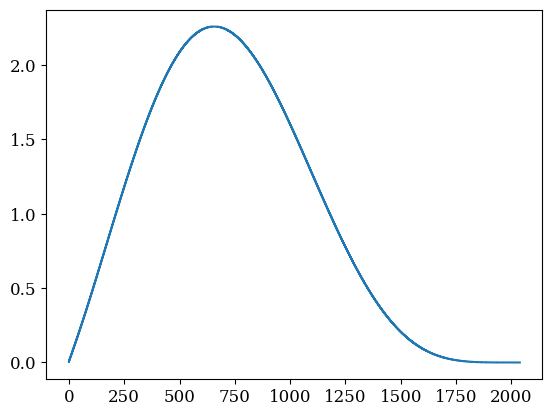

In [36]:
plt.step(np.arange(len(rh_curr_dist)), rh_curr_dist)